## Predict the Label of an Article : 1 if it is related to Police Violence on Black Community otherwise 0

In [1]:
import os
# directory where all files are 
os.chdir('/Users/luke/Desktop/Google Drive/Fall 2019/Capstone/Media Data Analysis/train')
print(os.getcwd())


/Users/luke/Desktop/Google Drive/Fall 2019/Capstone/Media Data Analysis/train


In [2]:
import pandas as pd 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
import pandas
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from datetime import date
import re
from xgboost import XGBClassifier
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.externals import joblib

/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


### Prepare Text Data

In [3]:
# to edit the files encoded differently : 
cols = ["id","Date","Link","Source", "Text","Title"]
dtypes={'speed':int, "Text":str}
df_2 = pd.read_csv("/Users/luke/Desktop/Google Drive/Fall 2019/Capstone/Media Data Analysis/n_train/WP1.csv", usecols=cols, dtype= dtypes)#, dtype = {‘c1’: str, ‘c2’: int, …})#, index_col=[0])
df_1 = pd.read_csv("/Users/luke/Desktop/Google Drive/Fall 2019/Capstone/Media Data Analysis/n_train/USA1.csv",encoding = 'unicode_escape',usecols=cols,  dtype= dtypes)#, index_col=[0])
df_3 = pd.read_excel("/Users/luke/Desktop/Google Drive/Fall 2019/Capstone/Media Data Analysis/n_train/ABC4.xlsx", usecols=cols, dtype= dtypes)#, index_col=0)
df_4 = pd.read_csv("/Users/luke/Desktop/Google Drive/Fall 2019/Capstone/Media Data Analysis/n_train/Newyork8.csv", usecols=cols, dtype= dtypes)#, index_col=[0])
df_4.shape

(600, 6)

In [4]:
#Refer Analysis for variations
# Reading all the files containing all sources articles
k=1
cols = ["id","Date","Link","Source", "Text","Title"]
for filename in os.listdir('.'):
    # reading xlsx file 
    if filename.endswith('.xlsx'):
        print(filename)
        if (k==1):
            
            d = pd.read_excel(filename, sheet_name=0, usecols=cols, dtype= dtypes)#, index=False)
            #print(d.head())
            k=k+1
        else:
            df = pd.read_excel(filename, sheet_name=0, usecols=cols, dtype= dtypes)#, index=False)
            d = pd.concat([d,df])
    # reading CSV file
    elif filename.endswith('.csv'):
        print(filename)
        if (k==1):
            d = pd.read_csv(filename,usecols=cols, dtype= dtypes)#,index=False )
            k=k+1
        else:
            df = pd.read_csv(filename,usecols=cols, dtype= dtypes)#, index=False)
            #print(df.head())
            d = pd.concat([d,df])
       
    
# combining the data of the previous cell with the data of the current cell            
d = pd.concat([d,df_1])   
d = pd.concat([d,df_2])
d = pd.concat([d,df_3])
d = pd.concat([d,df_4])
d.index = range(len(d))
d.head()

ABC1.csv
WSJ1-3.csv
CNN1.xlsx
CNN2.xlsx
ABC2_Nina_1.23.19_150.csv
CNN3.xlsx
FOXNEWS3.csv
FOXNEWS2.csv
FOXNEWS1.csv
NY2.csv
CNN4.csv
result1.csv
CNN5.csv


,id,Link,Title,Source,Date,Text
0,0.0,http://abcnews.go.com/Politics/mistletoe-mortg...,Mistletoe or mortgage payments? Gas or gifts? ...,ABCNEWS,12/22/18 16:48,They are janitors scrubbing toilets and mainte...
1,0.0,http://abcnews.go.com/US/miami-police-searchin...,Miami police searching for brazen armed robber...,ABCNEWS,12/22/18 15:00,Police officers in Miami are searching for bra...
2,0.0,http://abcnews.go.com/International/wireStory/...,"Sudan protests resume for 4th day over prices,...",ABCNEWS,12/22/18 12:10,Protests over worsening economic conditions re...
3,0.0,http://abcnews.go.com/International/wireStory/...,Guyana government falls in no-confidence vote,ABCNEWS,12/22/18 11:29,A lawmaker from the ruling coalition in Guyana...
4,0.0,http://abcnews.go.com/International/wireStory/...,Respite in Paris as yellow vest movement abates,ABCNEWS,12/22/18 9:24,"The yellow vest protests, which have brought p..."


### Preprocess Data    

In [6]:
for index in d.index:
    text = d.loc[index,"Text"]
    try:
        tmp = re.sub(r'\W', ' ', text)
    except:
        d.drop(index, inplace = True)
        continue
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text)
    text= text.lower()
    text = re.sub(r'\\n', ' ', text, flags=re.I)
    text = re.sub(r'\\', '', text, flags=re.I)
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    try:
        text= re.sub(r'\W', ' ', text)
    except:
        d.drop(index, inplace = True)
        continue
    d.loc[index,"Text"] =  text
d.shape

(1854, 6)

In [7]:
# drop duplicate rows of the input data
d.drop_duplicates(inplace = True, keep = "first")
print(d.shape)

(1825, 6)


In [8]:
# check how imbalamce the data is 
d['id'].value_counts()

0.0    1423
1.0     402
Name: id, dtype: int64

In [9]:
# changing id column (output variable) to integer
d["id"] = d.astype({"id": int})

### Upsampling 

In [10]:
#upsample (not required to run beacuse it does not give better result )
train_k = 300
train_x, X_test, train_y, y_test = train_test_split(  list(d["Text"].values), list(d["id"].values), random_state=20)
len(train_x)
l = np.bincount(np.array(train_y))
print(l)
np.bincount(np.array(y_test))


[1070  298]


array([353, 104])

In [11]:
# upsample(dont run)
train_d = pd.DataFrame({"Text": train_x, "id": train_y})

In [12]:
#up sample(don't run)
# Separate majority and minority classes
df_majority = train_d[train_d.id==0]
df_minority = train_d[train_d.id==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=957,    # to match majority class
                                 random_state=30) # reproducible results
 
# Combine majority class with upsampled minority class

df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.id.value_counts()

0    1070
1     957
Name: id, dtype: int64

In [13]:
#upsample (don't run)
X_train = df_upsampled.Text
#X_train = train_d.Text
y_train = df_upsampled.id
print(np.bincount(np.array(y_train)))

[1070  957]


### Transform Data and Modeling : Support Vector Machine

In [14]:
           
#train and test split of the input data (which is labelled 1 or 0)
# train_k = 300
X_train, X_test, y_train, y_test = train_test_split(  list(d["Text"].values), list(d["id"].values), random_state=20)

#tf-idfe_extraction(Tfid)
feature_extraction = TfidfVectorizer()
features = feature_extraction.fit_transform(X_train)

# train classifier SVM
clf = SVC(probability=True,C = 10, gamma = 0.1 )
#clf = RandomForestClassifier(criterion = 'gini', n_estimators=200, random_state=42) # random forest
print(np.bincount(np.array(y_train)))
print("----")
clf.fit(features, y_train)
# tf-idf for the test data
features_t = feature_extraction.transform(X_test)
# predict probabilities after converting data into numerical format using tfidf
predictions = clf.predict_proba(features_t)
print(np.bincount(predictions[:,1]>0.55))
# checking performance of the model
print("==========")
print("ROC-AUC" + str(roc_auc_score(y_test, predictions[:,1]>0.55)))
print("==================")


[1070  298]
----
[367  90]
ROC-AUC0.8331063412508172


#### Other Algorithms

In [14]:
# implementing naive bayes
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
k = features.todense()
model.fit(k, y_train)
print(model)
# make predictions
#expected = dataset.target
k_t = features_t.todense()
predicted = model.predict(k_t)
# summarize the fit of the model
print(metrics.classification_report(y_test, predicted))
print(metrics.confusion_matrix(y_test, predicted))
print(roc_auc_score(y_test, predicted))


GaussianNB(priors=None, var_smoothing=1e-09)
              precision    recall  f1-score   support

           0       0.83      0.98      0.89       353
           1       0.79      0.30      0.43       104

    accuracy                           0.82       457
   macro avg       0.81      0.64      0.66       457
weighted avg       0.82      0.82      0.79       457

[[345   8]
 [ 73  31]]
0.6377070167792548


In [15]:
# gradient boosting (either svm or this algorithm)

xgb = XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.1)
#score1 = cross_val_score(xgb,features, y_train, cv =10)
xgb.fit(features, y_train)
predictions = xgb.predict_proba(features_t)
print("ROC-AUC----" + str(roc_auc_score(y_test, predictions[:,1]>0.55)))
#print(score1.mean())

xgb.fit(features, y_train)
xgb.score(features_t, y_test)

ROC-AUC----0.8104843103072564


0.8927789934354485

### Parameter tuning

In [ ]:
# parameter tuning of SVM (don't run)

def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_
k = svc_param_selection(features, y_train, 5)
print(k)

In [59]:
# parameter tuning of boosting (don't run)

param_grid = { 
    'n_estimators': [200,300,500],
    'max_depth' : [3,5,6,7],
    'learning_rate' :[ 0.1, 0.15,0.01],
    'scale_pos_weight' :[0,1,2]
    
}
rfc = XGBClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)
grid_search.fit(features, y_train)
grid_search.best_params_


{'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 200,
 'scale_pos_weight': 1}

In [ ]:
# parameter tuning of random forest (don't run)

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8,10],
    'criterion' :['gini', 'entropy']
}
rfc=RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)
grid_search.fit(features, y_train)
grid_search.best_params_

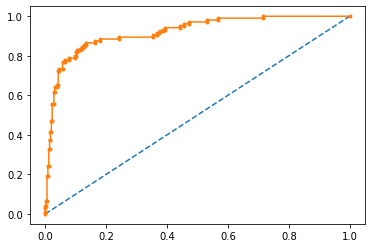

AUC: 0.921


In [23]:
# metrics for accuracy
from sklearn.metrics import roc_curve
import matplotlib.pyplot as pyplot
fpr, tpr, thresholds = roc_curve(y_test, predictions[:,1])
pyplot.plot([0, 1], [0, 1], linestyle='--')
pyplot.plot(fpr, tpr, marker='.')
pyplot.show()
auc_score = roc_auc_score(y_test, predictions[:,1])
print('AUC: %.3f' % auc_score)

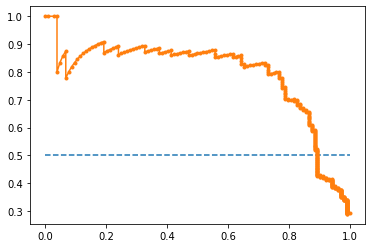

AUC: 0.791


In [24]:
# precision recall
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
precision, recall, thresholds = precision_recall_curve(y_test, predictions[:,1])
auc_score = auc(recall, precision)
pyplot.plot([0, 1], [0.5, 0.5], linestyle='--')
pyplot.plot(recall, precision, marker='.')
pyplot.show()
print('AUC: %.3f' % auc_score)

In [15]:
joblib.dump(clf, "model.pkl")

['model.pkl']

In [16]:
# directory for unlabeled data
os.chdir('/Users/luke/Desktop/Google Drive/Fall 2019/Capstone/Media Data Analysis/predict')
print(os.getcwd())

/Users/luke/Desktop/Google Drive/Fall 2019/Capstone/Media Data Analysis/predict


In [17]:
clf = joblib.load('../model.pkl')

In [18]:
# predicting the values for unlabeled data
i = 0
k=0
mp = 0
headers = ['id', 'link', 'header','source', 'date','text']
# writing the new rows after predicting the label in predict1.csv
with open(r"/Users/luke/Desktop/Google Drive/Fall 2019/Capstone/Media Data Analysis/predict/predict1.csv", 'a') as f:
    for filename in os.listdir('.'):
        print(filename)
        # unrelevant extension
        if(filename== ".DS_Store"):
            continue
        if(filename== "predict1.csv"):
            continue
        i=0
        if filename.endswith('.xlsx'):
            if (k==1):
                d = pd.read_excel(filename, sheetname=0)
                k=k+1
            else:
                d = pd.read_excel(filename, sheetname=0)
                #d = pd.concat([d,df])
        elif filename.endswith('.csv'):
            d = pd.read_csv(filename, encoding = "ISO-8859-1")
        else:
            pass

        for index in d.index:
    
            text = d.loc[index,"Text"]
            try:
                tmp = re.sub(r'\W', ' ', text)
            except:
                d.drop(index, inplace = True)
                continue
            text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
            text = re.sub(r'\^[a-zA-Z]\s+', ' ', text)
            text= text.lower()
            text = re.sub(r'\\n', ' ', text, flags=re.I)
            text = re.sub(r'\\', '', text, flags=re.I)
            text = re.sub(r'\s+', ' ', text, flags=re.I)
            try:
                text= re.sub(r'\W', ' ', text)
            except:
                d.drop(index, inplace = True)
                continue            
            d.loc[index,"Text"] =  text
            
        X_predict = list(d["Text"].values)
        # tf -idf 
        features_predict = feature_extraction.transform(X_predict)
        # predict using SVM trained model
        y_predict = clf.predict_proba(features_predict)
        
        y= y_predict[:,1].tolist()
       
        for index, row in d.iterrows():
            if y[i] >0.55:
                d.loc[index,"id"] =1
            else: 
                d.loc[index,"id"] = 0 
            i = i+1
        if mp== 0:
            d.to_csv(f, header=True)
            mp = 1
        else:
            d.to_csv(f,header=False )

WP15.csv
USA5.csv
NYj5.csv
NY15.csv
NY29.csv
NY14.csv
USA4.csv
WP28.csv
WP14.csv
WP16.csv
NY16.csv
NY17.csv
WP17.csv
WP13.csv
USA3.csv
.DS_Store
NYj3.csv
NY13.csv
NY12.csv
NYj2.csv
USA2.csv
WP12.csv
NY9.csv
WP10.csv
NY11.csv
NYj1.csv
USA1.csv
NY8.csv
WP11.csv
WP2.csv
Newyork2.csv
wsj4.csv
wsj5.csv
Newyork3.csv
WP3.csv
WP1.csv
Newyork1.csv
wsj7.csv
wsj6.csv
WP4.csv
Newyork4.csv
wsj2.csv
wsj3.csv
Newyork5.csv
WP5.csv
WP7.csv
Newyork7.csv
wsj1.csv
Newyork6.csv
predict1.csv
WP6.csv
WP8.csv
Newyork8.csv
WP9.csv
WP20.csv
NY5.csv
NY20.csv
NY21.csv
NY4.csv
WP21.csv
WP23.csv
NY6.csv
NY23.csv
NY22.csv
NY7.csv
WP22.csv
NY3.csv
WP26.csv
NY26.csv
NY32.csv
NY27.csv
WP27.csv
NY2.csv
WP19.csv
WP25.csv
NY19.csv
NY31.csv
NY25.csv
NY24.csv
NY30.csv
NY18.csv
WP24.csv
WP18.csv
NY1.csv
